## Necessary libraries

In [35]:
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gspread

In [36]:
def compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake=50):
    Lx, Ly, Lz = box_lengths
    n_flakes = len(flake_positions) // beads_per_flake
    flake_coms = []

    for i in range(n_flakes):
        flake = flake_positions[i * beads_per_flake : (i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        com = np.mean(unwrapped, axis=0)

        # Wrap CoM into [-L/2, L/2]
        com[0] = (com[0] + Lx/2) % Lx - Lx/2
        com[1] = (com[1] + Ly/2) % Ly - Ly/2
        com[2] = (com[2] + Lz/2) % Lz - Lz/2

        flake_coms.append(com)

    return np.array(flake_coms)
    

In [37]:
def count_clusters(flake_coms, box_lengths, cutoff):
    Lx, Ly, Lz = box_lengths
    n = len(flake_coms)
    adjacency = [set() for _ in range(n)]

    # Build adjacency list using MIC
    for i in range(n):
        for j in range(i + 1, n):
            dr = flake_coms[j] - flake_coms[i]
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)
            dist = np.linalg.norm(dr)
            if dist < cutoff:
                adjacency[i].add(j)
                adjacency[j].add(i)

    visited = set()
    clusters = []

    # DFS to build clusters
    for i in range(n):
        if i not in visited and adjacency[i]:
            cluster = []
            stack = [i]
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    cluster.append(current)
                    stack.extend(adjacency[current] - visited)
            if len(cluster) > 1:  # Only count as cluster if size > 1
                clusters.append(cluster)

    return len(clusters), [len(c) for c in clusters]


In [38]:
def analyze_clusters_over_time(traj, start=0, step=1000, cutoff=2.5, beads_per_flake=50):
    times = []
    n_clusters_list = []
    avg_cluster_sizes = []

    for frame_idx in range(start, len(traj), step):
        frame = traj[frame_idx]
        box_lengths = frame.configuration.box[:3]

        flake_type = "F"
        flake_typeid = frame.particles.types.index(flake_type)
        positions = frame.particles.position
        typeids = frame.particles.typeid
        flake_positions = positions[typeids == flake_typeid]

        flake_coms = compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake)
        n_clusters, sizes = count_clusters(flake_coms, box_lengths, cutoff)

        times.append(frame_idx)
        n_clusters_list.append(n_clusters)
        avg_cluster_sizes.append(np.mean(sizes) if sizes else 0)

    return times, n_clusters_list, avg_cluster_sizes

# Adjust to whichever file you're trying to analyze, then hit run until the end

In [39]:
start_file = "50_10mer5f_0.005dt_4.0kT_start.txt"
traj_file = "50_10mer5f_0.005dt_4.0kT.gsd"
with open(start_file) as f:
    print(f.readlines()[0].strip())

500


In [40]:
with open(start_file) as f:
    start = int(f.readlines()[0].strip()) # extracting post-shrink sim beginning frame
traj = gsd.hoomd.open(traj_file)
times, n_clusters, avg_sizes = analyze_clusters_over_time(
    traj,
    start=start,   # post-shrink
    step=1, # analyze every "x" frame, leave this at 1
    cutoff=2.5
) # this function is used to initially calculate the decorrelation time, so that we know every how many certain amount of frames to analyze. 

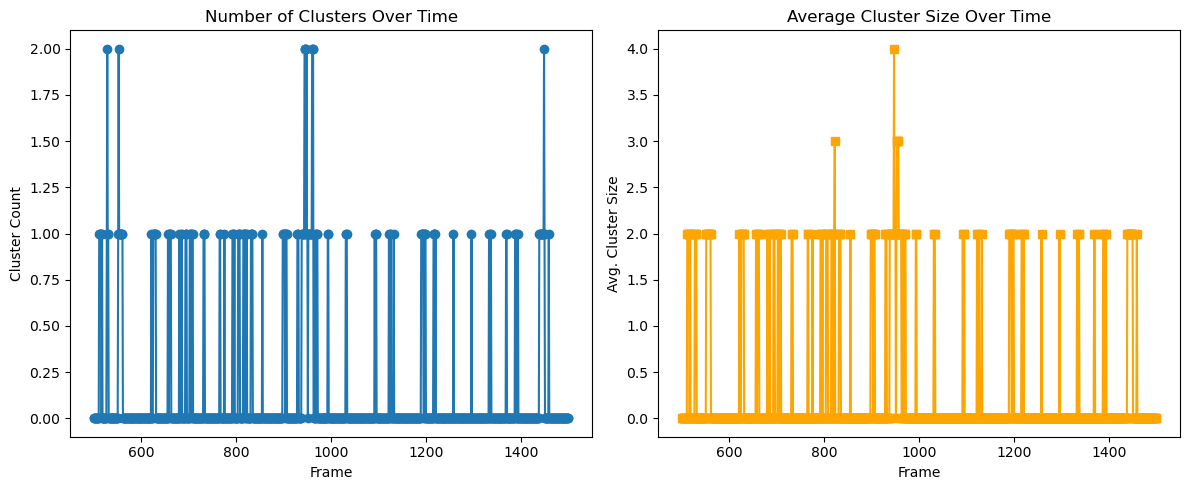

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(times, n_clusters, marker='o')
plt.title("Number of Clusters Over Time")
plt.xlabel("Frame")
plt.ylabel("Cluster Count")

plt.subplot(1, 2, 2)
plt.plot(times, avg_sizes, marker='s', color='orange')
plt.title("Average Cluster Size Over Time")
plt.xlabel("Frame")
plt.ylabel("Avg. Cluster Size")

plt.tight_layout()
plt.show()

In [42]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))  
    acorr = np.fft.irfft(ft * np.conjugate(ft))  
    acorr /= (len(array) * np.var(array))        

    dt = np.where(acorr < 0)[0][0]               
    nsamples = len(array) // dt                  

    acorr = acorr[dt:nsamples]                  

    return nsamples, dt
n, dt = autocorr1D(avg_sizes)

# Decorrelation time is now calculated; now we can plot all the independent samples present within this simulation. Lower independent samples means more average aggregation over time is occurring, should occur as kT is increased. 

In [43]:
print("Independent samples and decorrelation time:", n, dt)

Independent samples and decorrelation time: 52 19


In [44]:
# now we can plot every "dt"th frame, whose length should be ~= independent samples
decorrelated_times = times[::dt]
decorrelated_sizes = avg_sizes[::dt]
decorrelated_clusters = n_clusters[::dt]

In [45]:
print(len(decorrelated_sizes)) # verifying it is equal to calculated independent sampleses))

53


Text(0, 0.5, 'Avg Cluster Size')

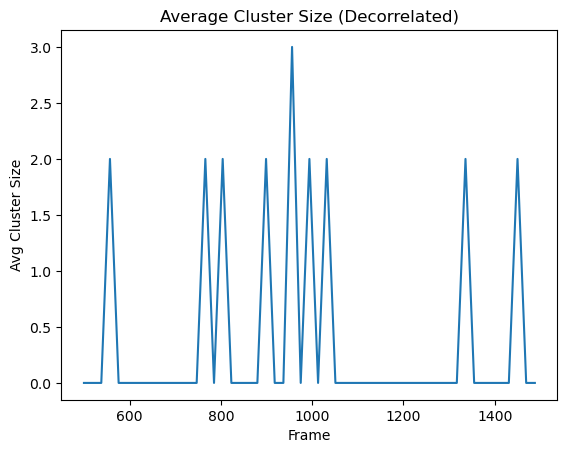

In [46]:
plt.plot(decorrelated_times, decorrelated_sizes) # plot of every independent sample in simulation
plt.title("Average Cluster Size (Decorrelated)")
plt.xlabel("Frame")
plt.ylabel("Avg Cluster Size")

In [47]:
np.mean(decorrelated_sizes)

0.3584905660377358

In [48]:
np.mean(decorrelated_clusters)

0.16981132075471697

Text(0, 0.5, '# Clusters')

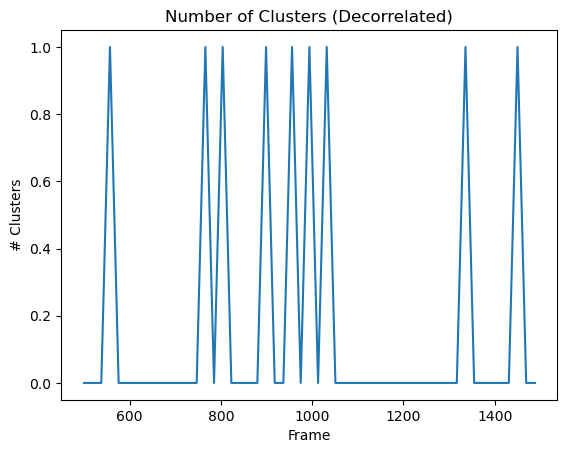

In [49]:
plt.plot(decorrelated_times, decorrelated_clusters)
plt.title("Number of Clusters (Decorrelated)")
plt.xlabel("Frame")
plt.ylabel("# Clusters")

In [50]:
# Add additional data to start_file
decorrelated_values = [len(decorrelated_sizes), np.mean(decorrelated_sizes), np.mean(decorrelated_clusters)]
values_to_add = [str(val) + '\n' for val in decorrelated_values]
with open(start_file, 'a') as f:
    f.write(str(len(decorrelated_sizes)) + '\n')
    f.write(str(np.mean(decorrelated_sizes)) + '\n')
    f.write(str(np.mean(decorrelated_clusters)) + '\n')

In [51]:
# Add to Google Sheet
service_account_file = "../service_worker1.json"

gc = gspread.service_account(filename=service_account_file)

spreadsheet = gc.open("Mxene Project Data")
worksheet = spreadsheet.worksheet("Data")
data = worksheet.get_all_values()
print(f"Successfully read {len(data)} rows from the sheet.")

with open(start_file, 'r') as f:
    new_row_data = f.readlines()[1:]

worksheet.append_row(new_row_data)

Successfully read 32 rows from the sheet.


{'spreadsheetId': '1QYU0zOIGrmV0kvb3ULiIUumNB7fkqxRUz9SBWGRnfEk',
 'tableRange': 'Data!A1:P32',
 'updates': {'spreadsheetId': '1QYU0zOIGrmV0kvb3ULiIUumNB7fkqxRUz9SBWGRnfEk',
  'updatedRange': 'Data!A33:P33',
  'updatedRows': 1,
  'updatedColumns': 16,
  'updatedCells': 16}}